# How to perform PRF photometry?

In previous tutorials we discussed [how aperture photometry works](1.03-what-are-lightcurves.html) and how you can [create your own custom masks](2.05-making-custom-apertures.html) to extract aperture photometry.

As a reminder, aperture photometry works by summing up the flux values across all the pixels in a pre-defined mask.  It tends to offer the fastest and most robust way to extract photometry for an isolated star, but it suffers from the three limitations:
1. When two or more stars overlap, aperture photometry will return the sum of the flux of all stars.  Separating their signals requires additional assumptions.
2. When the telescope experience motion or focus changes, the fraction of the flux of a star captured by the pre-defined aperture mask will change.  This imposes systematics on the data which need to be removed (e.g. using the CBV or SFF techniques).
3. It may be difficult to separate a background signal from the lightcurve of a star. In particular, this is a concern when time-varying background signals are present, such as the so-called "rolling bands" in Kepler.

An alternative to aperture photometry which addresses the above limitations is called called *Point Response Function (PRF) model fitting photometry*, also known as *Point Spread Function (PSF) fitting photometry* or *PRF (PSF) photometry* in short. In this method, a parameterized model is fit to the data. This method is significantly more complicated then aperture photometry and is prone to a different set of systematics.  However it offers the ability to separate the signals of overlapping stars in very crowded regions or star clusters.

This tutorial demonstrates how *lightkurve* can be used to extract lightcurves using the model fitting technique.  We will start with an easy example and then show how you can tune the parameters of the model to create more careful analyses.

## Table of contents

1. Simple example: PRF photometry of Kepler-10
2. The `TPFModel` object
3. Visualizing and fitting a `TPFModel` object
4. Changing `TPFModel` priors
5. Creating lightcurves with a custom `TPFModel` object


## Simple example: PRF photometry of Kepler-10

Let's start with a simple example by obtaining PRF photometry for planet system *Kepler-10*. We start by downloading the pixel data from the archive:

In [1]:
from lightkurve import KeplerTargetPixelFile
tpf = KeplerTargetPixelFile.from_archive("Kepler-10", quarter=3, quality_bitmask='hardest')

The easiest way to get PRF photometry is to simply call the `to_lightcurve` method with parameter `method='prf'`. This will fit the pixel data of all cadences with a default model and return the lightcurve.

Fitting cadences: 100%|██████████| 3634/3634 [00:59<00:00, 60.90it/s]


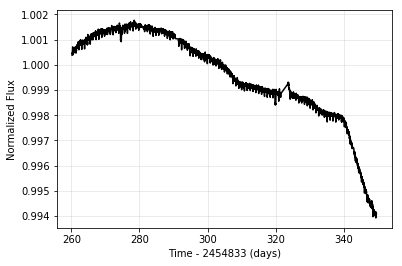

In [2]:
lc = tpf.to_lightcurve(method='prf')
lc.plot()

A good way to verify that the model-fitting photometry produced a sensible output is by comparing it against standard aperture photometry.  You can obtain aperture photometry using the same `to_lightcurve` method and the parameter `method='aperture'` (which is the default value of this parameter).

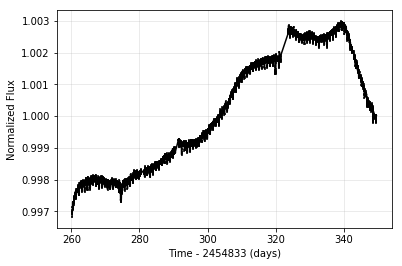

In [3]:
lc_aper = tpf.to_lightcurve(method='aperture')
lc_aper.plot()

There is a notable difference in the long-term trend in both lightcurves.  This is because PRF-fitting photometry yields a local estimate of the background which is often different from the Kepler pipeline's global background level estimates.

Let's fold both lightcurves on the period of the known planet *Kepler-10 b* to show that the transit can be recovered equally well: 

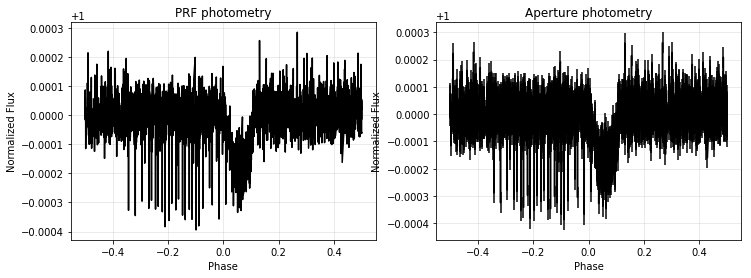

In [4]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].set_title('PRF photometry')
lc.flatten().fold(period=0.8376).plot(ax=ax[0])
ax[1].set_title('Aperture photometry')
lc_aper.flatten().fold(period=0.8376).plot(ax=ax[1])

Success!  Note that the outliers between *phase* -0.4 and 0.0 are caused by the transits of another planet with a different period.

Note that PRF photometry appears to offer a few percent less noise compared to its aperture counterpart:

In [5]:
print("""The CDPP noise metric equals:
{:.1f} ppm for PRF-fitting photometry;
{:.1f} ppm for aperture photometry.""".format(lc.cdpp(), lc_aper.cdpp()))

The CDPP noise metric equals:
32.4 ppm for PRF-fitting photometry;
32.7 ppm for aperture photometry.


This is all you need to know to get started with PRF photometry!  In what follows, we explain how you can tune the parameters of the model fitting.

## The `TPFModel` object

It is often possible to obtain better results by carefully tuning the model that is being fit to the data. This is true in particular when the data contain multiple overlapping stars.  Let's have a look at how you can interact and change the model.

*Lightkurve* uses objects of type `TPFModel` to specify the model. 
You can obtain the default model using the `get_model()` method:

In [6]:
model = tpf.get_model()
type(model)

lightkurve.prf.tpfmodel.TPFModel

A `TPFModel` object encapsulates our beliefs about the stars contained in a pixel file.  The key parameters are:

* `model.star_priors` captures our prior beliefs about the positions and fluxes of the point sources in the data using a list of `StarPrior` objects.  Each `StarPrior` object is parameterized by `col` and `row` in pixel coordinates and `flux` in electrons/second;
* `model.background_prior` captures our beliefs about the per-pixel background, parameterized by `flux` in electrons/second;
* `model.focus_prior` captures our beliefs on the focus of the spacecraft, parameterized by the unit-less stretch factors `scale_col` and `scale_row`, and `rotation_angle` in radians;
* `model.motion_prior` captures our beliefs about spacecraft motion, parameterized by `shift_col` and `shift_row` in pixel coordinates; 
* `model.prfmodel` an object of type `KeplerPRF` which models the Point Response Function.
* `model.fit_background`, `model.fit_focus`, and `model.fit_motion` are booleans which indicate whether or not the background, focus, and motion parameters should be considered free parameters, i.e. whether or not our beliefs should assumed to be perfect.

The parameters of each of these components are prior distributions.

We can inspect the our beliefs by accessing the properties, for example, this is the prior on the column pixel coordinate of the star in our data:

In [7]:
model.star_priors[0].col

<GaussianPrior(mean=[655.70045778], var=[0.00046541])>

And this is the model's prior on the background flux:

In [8]:
model.background_prior.flux

<GaussianPrior(mean=[140.05336], var=[145.87004587])>

We can inspect all the parameters at once using the `print` function:

In [9]:
print(model)

  <StarPrior(
    col=<GaussianPrior(mean=[655.70045778], var=[0.00046541])>
    row=<GaussianPrior(mean=[246.83753465], var=[0.0007464])>
    flux=<UniformPrior(lb=[83941.5390625], ub=[1066484.375])>
    targetid=11904151)>
  <BackgroundPrior(
    flux=<GaussianPrior(mean=[140.05336], var=[145.87004587])>)>
  <FocusPrior(
    scale_col=<GaussianPrior(mean=[1], var=[0.0001])>
    scale_row=<GaussianPrior(mean=[1], var=[0.0001])>
    rotation_angle=<UniformPrior(lb=[-3.1415], ub=[3.1415])>)>
  <MotionPrior(
    shift_col=<GaussianPrior(mean=[0], var=[1.])>
    shift_row=<GaussianPrior(mean=[0], var=[1.])>)>
  fit_background=True
  fit_focus=False
  fit_motion=False



## Visualizing and fitting a `TPFModel` object

A `TPFModel` object contains several methods to interact with the model.  For example, you can visualize the default prediction using the `plot()` method.  This will visualize the model prediction using the prior means.  Let's plot the model below (left panel) and compare it against the observed data (right panel):

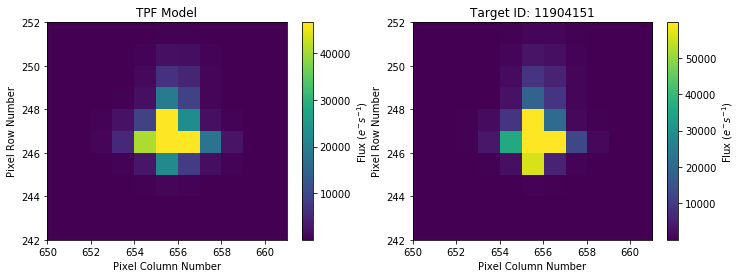

In [10]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
model.plot(ax=ax[0])
tpf.plot(ax=ax[1]);

You can fit the model to a single cadence of pixel data using the `fit()` method, which returns an object of type `TPFModelParameters` which encapulsates the maximum likelihood values of the parameters for that cadence:

In [11]:
parameters = model.fit(tpf.flux[0] + tpf.flux_bkg[0])
print(parameters)

  <StarParameters(
    col=655.6410020402017
    row=246.75968163502935
    flux=528781.7188502487
    targetid=None)>
  <BackgroundParameters(
    flux=175.2389710561001
    fitted=True)>
  <FocusParameters(
    scale_col=[1]
    scale_row=[1]
    rotation_angle=[0.]
    fitted=False)>
  <MotionParameters(
    shift_col=[0]
    shift_row=[0]
    fitted=False)>
  residual_image:
    [ 13.5211913  -24.99054271 -36.49246532 -36.4521516 ...
  predicted_image:
    [175.23897106 175.23897106 175.23897106 175.23897106...



For example, we can access the maximum likelihood value of the stellar flux as follows:

In [12]:
parameters.stars[0].flux

528781.7188502487

And the background flux was found to be:

In [13]:
parameters.background.flux

175.2389710561001

We can visualize the model again, this time passing the fitted parameters:

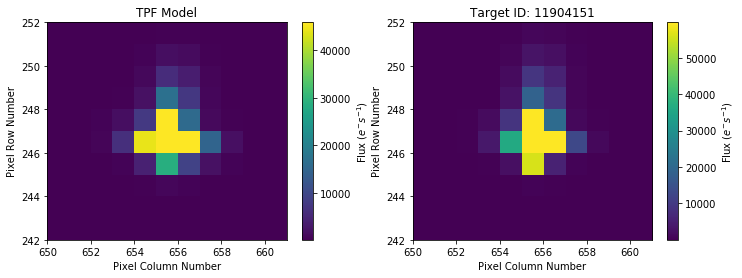

In [14]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
model.plot(parameters, ax=ax[0])
tpf.plot(ax=ax[1])

## Changing `TPFModel` priors

We can change a `TPFModel` by manipulating its properties.  For example, we can add a star to the lower right corner of the pixel file as follows:

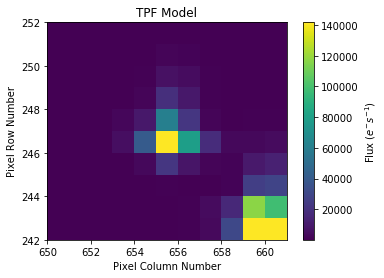

In [15]:
from lightkurve.prf import StarPrior
model = tpf.get_model()
model.star_priors.append(StarPrior(col=660, row=243, flux=1e6))
model.plot()

Alternatively, you can build a `TPFModel` from scratch.  In the example below, we use an arbitrary combination of Gaussian, Uniform, and Fixed priors to initialize a model. Note that the ideal choices for these assumptions depend strongly on your scientific objectives and may require trial-and-error.

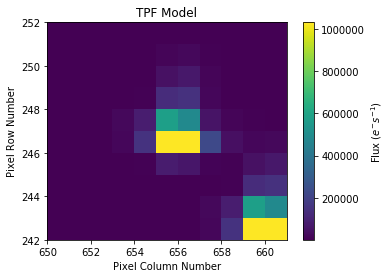

In [16]:
from lightkurve.prf import TPFModel, StarPrior, BackgroundPrior, FocusPrior, MotionPrior
from lightkurve.prf import GaussianPrior, UniformPrior, FixedValuePrior
model = TPFModel(star_priors=[StarPrior(col=GaussianPrior(mean=656, var=1),
                                        row=GaussianPrior(mean=247, var=1),
                                        flux=UniformPrior(lb=0, ub=1e7)),
                              StarPrior(col=FixedValuePrior(value=660),
                                        row=FixedValuePrior(value=243),
                                        flux=UniformPrior(lb=0, ub=1e7))],
                 background_prior=BackgroundPrior(flux=GaussianPrior(mean=100., var=10.)),
                 focus_prior=FocusPrior(scale_col=GaussianPrior(mean=1, var=0.0001),
                                        scale_row=GaussianPrior(mean=1, var=0.0001),
                                        rotation_angle=UniformPrior(lb=-3.1415, ub=3.1415)),
                 motion_prior=MotionPrior(shift_col=GaussianPrior(mean=0., var=0.01),
                                          shift_row=GaussianPrior(mean=0., var=0.01)),
                 prfmodel=tpf.get_prf_model(),
                 fit_background=True,
                 fit_focus=False,
                 fit_motion=False)
model.plot()

## Creating lightcurves with a custom `TPFModel` object

Above we demonstrated how you can interact with a `TPFModel` and fit its parameters to a single cadence.  Most users will be interested in obtaining a lightcurve by fitting the model to *all* the cadences rather than a single one.

To make this easy, *lightkurve* provides a helper class called `PRFPhotometry`, which makes it easy to fit the model to all cadences and inspect the results.  For example:

Fitting cadences: 100%|██████████| 3634/3634 [00:47<00:00, 76.85it/s]


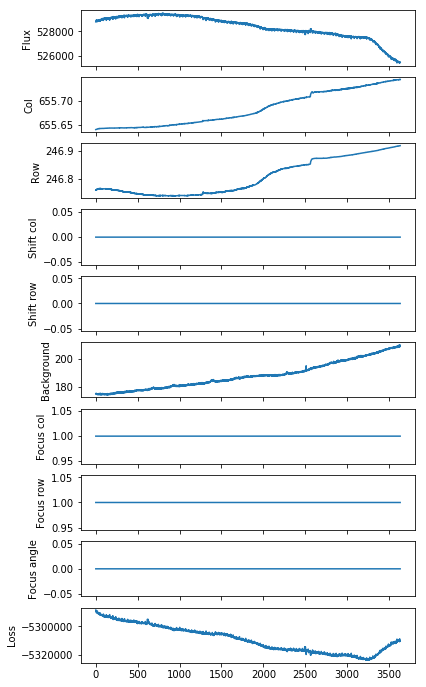

In [17]:
from lightkurve import PRFPhotometry
prfphot = PRFPhotometry(model=tpf.get_model())
prfphot.run(tpf.flux + tpf.flux_bkg)
prfphot.plot_results()

You can access the details of the fit in each cadence using the `prfphot.results` property, e.g.:

In [18]:
prfphot.results[0].stars[0].flux

528781.7188502487

Alternative, you can access the fitted fluxes as a `LightCurve` object:

In [19]:
prfphot.lightcurves[0]

Note that the focus and motion parameters in the example above are constant. This is because the `fit_focus` and `fit_motion` parameters were set to `False` in the model.  By setting these to `True`, we can potentially improve the quality of the fit. Beware however, this comes at the cost of slowing down the fitting process and potentially introducing more complicated systematics and parameter degeneracies.

Fitting cadences: 100%|██████████| 3634/3634 [03:04<00:00, 19.69it/s]


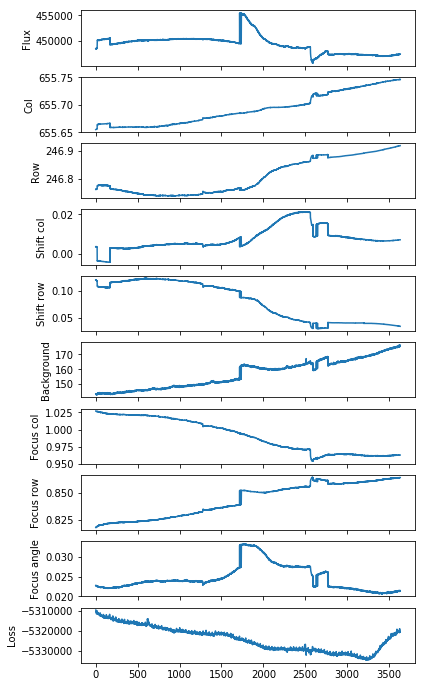

In [20]:
prfphot.model.fit_focus = True
prfphot.model.fit_motion = True
prfphot.run(tpf.flux + tpf.flux_bkg)
prfphot.plot_results()

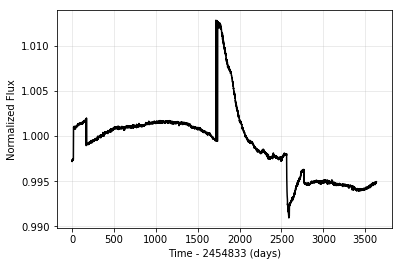

In [21]:
prfphot.lightcurves[0].plot()

Uhoh, the increased model flexibility introduced complicated systematics.  These systematics are caused in part by the degeneracy between the star's `col` and `row` position and the `shift_col` and `shift_row` parameters. The degeneracy will disappear when additional stars are present in the data, or when tighter priors are employed.

## Comments?

At present we are evaluating the design and use of *lightkurve*'s PRF photometry for use in crowded fields.  If you encounter issues, or would like to contribute a tutorial or working example, then please open an issue or pull request on GitHub!